In [69]:
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
from matplotlib import font_manager, rc
import matplotlib.font_manager as fm
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

plt.rcParams['axes.unicode_minus'] = False

import seaborn as sns
import numpy as np

In [3]:
import sklearn
print(sklearn.__version__)

1.5.1


In [71]:
df = pd.read_pickle("C:/ZIPcoding/final_encoded_df.pkl")

In [18]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 515083 entries, 0 to 515082
Data columns (total 62 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   자치구코드          515083 non-null  int32         
 1   법정동코드          515083 non-null  int32         
 2   전체코드           515083 non-null  object        
 3   자치구명           515083 non-null  object        
 4   법정동명           515083 non-null  object        
 5   자치구법정동         515083 non-null  object        
 6   계약일            515083 non-null  datetime64[ns]
 7   평당가격           515083 non-null  float64       
 8   실거래가           515083 non-null  int32         
 9   geometry       515083 non-null  geometry      
 10  포함지하철역         515083 non-null  object        
 11  환승역개수          515083 non-null  int64         
 12  일반역개수          515083 non-null  int64         
 13  1호선개수          515083 non-null  int64         
 14  2호선개수          515083 non-null  int64       

In [72]:
selected_features = ['토지면적표준편차_3개월',
                         '실거래가',
                         '평균거래량_3개월',
                         '건물면적_PCA_3개월',
                         '서울5대학군지여부_1',
                         '한강변여부_1',
                         '수인분당선개수',
                         '3호선개수',
                         '층평균_6개월']

In [73]:
df_for_predict = df.loc[(df['계약일'] >= '2024-08-12')]

In [74]:
df_for_modeling = df.loc[(df['계약일'] < '2024-08-12')]

## 모델 비교

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 데이터 준비 (변수 선택)
selected_features

# 결측치 처리
df_for_modeling = df_for_modeling.replace([np.inf, -np.inf], np.nan).dropna(subset=selected_features + ['평당가격_6개월후'])

# 독립변수(X)와 종속변수(y) 설정
X = df_for_modeling[selected_features]
y = df_for_modeling['평당가격_6개월후']

# 데이터 분할 (80% 학습, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 여러 모델 비교를 위한 딕셔너리
models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "CatBoost": CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, random_seed=42, verbose=0),
    "XGBoost": xgb.XGBRegressor(n_estimators=500, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1),
    "LightGBM": lgb.LGBMRegressor(n_estimators=500, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=500, max_depth=6, learning_rate=0.1, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=500, learning_rate=0.1, random_state=42),
}

# 성능 저장용 리스트
results = []

# 모델 학습 및 평가
for name, model in models.items():
    model.fit(X_train, y_train)  # 모델 학습
    y_pred = model.predict(X_test)  # 예측

    # 성능 평가
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2,
    })

# 결과 출력
results_df = pd.DataFrame(results).sort_values(by="R²", ascending=False)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1287
[LightGBM] [Info] Number of data points in the train set: 378997, number of used features: 9
[LightGBM] [Info] Start training from score 3350.198948


In [45]:
results_df

,Model,MAE,MSE,RMSE,R²
0,RandomForest,332.045245,5.824033e+05,763.153550,0.819507
2,XGBoost,847.367133,1.473364e+06,1213.822115,0.543388
4,GradientBoosting,867.414850,1.510248e+06,1228.921469,0.531957
3,LightGBM,884.090122,1.594646e+06,1262.792824,0.505801
1,CatBoost,917.286842,1.708764e+06,1307.196842,0.470435
5,AdaBoost,1347.433526,3.025649e+06,1739.439307,0.062317


## 랜덤포레스트 기본 모델 학습

In [28]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 결측치 및 이상치 처리
df_for_modeling = df_for_modeling.replace([np.inf, -np.inf], np.nan).dropna(subset=selected_features + ['평당가격_6개월후'])

# 독립변수(X)와 종속변수(y) 설정
X = df_for_modeling[selected_features]
y = df_for_modeling['평당가격_6개월후']

# 학습 데이터와 테스트 데이터 분리 (80% 학습, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 모델 생성 및 학습
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 예측 수행
y_pred = rf_model.predict(X_test)

# 성능 평가
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"📌 모델 성능 평가")
print(f"MAE (평균 절대 오차): {mae:.4f}")
print(f"MSE (평균 제곱 오차): {mse:.4f}")
print(f"RMSE (평균 제곱근 오차): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


📌 모델 성능 평가
MAE (평균 절대 오차): 332.0452
MSE (평균 제곱 오차): 582403.3408
RMSE (평균 제곱근 오차): 763.1535
R² Score: 0.8195


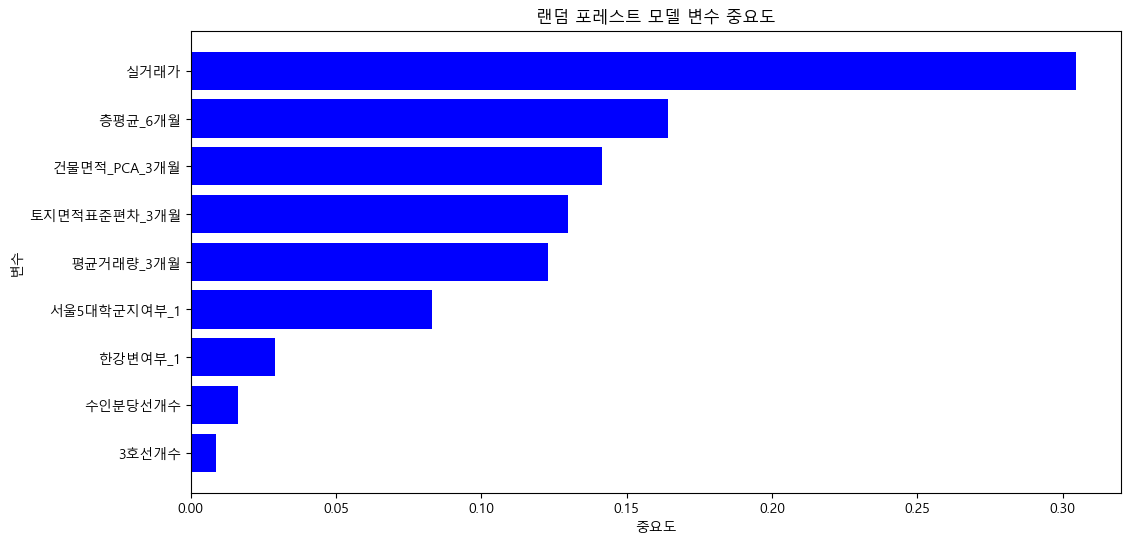

In [30]:
# 변수 중요도 추출
feature_importances = pd.DataFrame({
    'Feature': selected_features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# 변수 중요도 시각화
plt.figure(figsize=(12, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='blue')
plt.xlabel('중요도')
plt.ylabel('변수')
plt.title('랜덤 포레스트 모델 변수 중요도')
plt.gca().invert_yaxis()  # 중요도가 높은 순으로 정렬
plt.show()


In [36]:
import joblib

# 모델 저장
joblib.dump(rf_model, "C:/ZIPcoding/model/rf_model_ver1.joblib")

['C:/ZIPcoding/model/rf_model_ver1.joblib']

## 교차 검증

### K fold 교차검증 수행

In [47]:
from sklearn.model_selection import cross_val_score, KFold

# KFold 설정 (5-폴드 교차검증)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 랜덤 포레스트 모델
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# 교차 검증 수행 (평가 지표: 음수가 아닌 MSE)
mse_scores = -cross_val_score(rf_model, X, y, cv=kf, scoring='neg_mean_squared_error')

# 교차 검증 결과 출력
print(f"개별 MSE 점수: {mse_scores}")
print(f"평균 MSE: {mse_scores.mean()}")


개별 MSE 점수: [583153.79811872 564540.01238794 592371.73254161 570813.32567919
 581347.85332014]
평균 MSE: 578445.3444095206


In [50]:
import numpy as np

# RMSE 계산
rmse_scores = np.sqrt(mse_scores)

print(f"KFold 개별 RMSE 점수: {rmse_scores}")
print(f"KFold 평균 RMSE: {rmse_scores.mean()}")


KFold 개별 RMSE 점수: [763.64507339 751.35877741 769.65689274 755.52188961 762.46170613]
KFold 평균 RMSE: 760.5288678569117


# 성능 개선

## 하이퍼파라미터 튜닝

In [54]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# 하이퍼파라미터 후보 설정
param_grid = {
    'n_estimators': [50, 100, 200],  # 트리 개수
    'max_depth': [None, 10, 20],     # 최대 깊이
    'min_samples_split': [2, 5, 10], # 노드를 나누는 최소 샘플 수
    'min_samples_leaf': [1, 2, 4]    # 리프 노드의 최소 샘플 수
}

# K-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 랜덤 포레스트 모델 생성
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

# GridSearchCV 설정 (MSE 최소화 목표)
grid_search = GridSearchCV(rf_model, param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# 교차 검증 실행 (최적의 파라미터 탐색)
grid_search.fit(X, y)

# 최적의 하이퍼파라미터 출력
print(f"최적의 하이퍼파라미터: {grid_search.best_params_}")

# 최적의 모델 성능 출력
print(f"최적의 MSE: {-grid_search.best_score_}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
최적의 하이퍼파라미터: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
최적의 MSE: 574827.995806539


In [57]:
grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error', verbose=2)

In [61]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,163.407181,6.382165,15.056992,0.883381,None,1,2,50,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",-592107.553581,-571333.420419,-601895.398775,-579150.189490,-588630.274470,-586623.367347,10554.333547,3
1,307.662496,3.458927,17.567001,1.391034,None,1,2,100,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",-583153.798119,-564540.012388,-592371.732542,-570813.325679,-581347.853320,-578445.344410,9758.528057,2
2,560.822339,1.338466,56.483988,4.730785,None,1,2,200,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",-579123.819187,-560525.328975,-588634.514817,-567593.812066,-578262.503988,-574827.995807,9775.168592,1
3,164.429233,5.635550,16.353711,0.728452,None,1,5,50,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",-617641.166386,-595494.966019,-624951.071424,-603302.141579,-614156.733254,-611109.215733,10471.923532,6
4,303.243714,2.178807,17.904925,3.155656,None,1,5,100,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",-608422.854108,-590003.019794,-615566.425027,-594476.648707,-606543.189006,-603002.427328,9396.228554,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,243.910152,0.756685,11.523620,0.720555,20,4,5,100,"{'max_depth': 20, 'min_samples_leaf': 4, 'min_...",-950846.201235,-942532.409521,-960611.594877,-934990.016713,-952487.496590,-948293.543787,8786.514479,49
77,423.952255,12.841796,10.955929,4.765475,20,4,5,200,"{'max_depth': 20, 'min_samples_leaf': 4, 'min_...",-947508.030005,-940054.019906,-959211.109621,-932685.952710,-951218.114945,-946135.445437,9127.574735,46
78,136.406807,4.321961,15.342336,1.841145,20,4,10,50,"{'max_depth': 20, 'min_samples_leaf': 4, 'min_...",-971558.608793,-963276.245011,-980449.838575,-954919.846833,-970950.221111,-968230.952065,8596.552279,54
79,234.646257,0.965327,9.464103,1.041852,20,4,10,100,"{'max_depth': 20, 'min_samples_leaf': 4, 'min_...",-964212.760910,-956398.580551,-973934.707275,-948222.615611,-965597.490903,-961673.231050,8728.502966,53


In [63]:
results_df[['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 
            'param_min_samples_leaf', 'mean_test_score']]

,param_n_estimators,param_max_depth,param_min_samples_split,param_min_samples_leaf,mean_test_score
0,50,None,2,1,-586623.367347
1,100,None,2,1,-578445.344410
2,200,None,2,1,-574827.995807
3,50,None,5,1,-611109.215733
4,100,None,5,1,-603002.427328
...,...,...,...,...,...
76,100,20,5,4,-948293.543787
77,200,20,5,4,-946135.445437
78,50,20,10,4,-968230.952065
79,100,20,10,4,-961673.231050


In [65]:
results_df[['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 
            'param_min_samples_leaf', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False).head(5)


,param_n_estimators,param_max_depth,param_min_samples_split,param_min_samples_leaf,mean_test_score
2,200,None,2,1,-574827.995807
1,100,None,2,1,-578445.344410
0,50,None,2,1,-586623.367347
5,200,None,5,1,-599623.269696
4,100,None,5,1,-603002.427328


In [71]:
# results_df.to_pickle("C:/ZIPcoding/model/grid_search_result.pkl")

In [224]:
grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error', verbose=2)

In [228]:
import pickle

with open('C:/ZIPcoding/model/grid_search.pkl', 'wb') as f:
    pickle.dump(grid_search, f)

### 최적의 하이퍼파라미터로 학습

In [79]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 결측치 및 이상치 처리
df_for_modeling = df_for_modeling.replace([np.inf, -np.inf], np.nan).dropna(subset=selected_features + ['평당가격_6개월후'])

# 독립변수(X)와 종속변수(y) 설정
X = df_for_modeling[selected_features]
y = df_for_modeling['평당가격_6개월후']

# 학습 데이터와 테스트 데이터 분리 (80% 학습, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 최적의 하이퍼파라미터 전달 방식
rf_model_hp = RandomForestRegressor(max_depth=None,
                                min_samples_leaf=1,
                                min_samples_split=2,
                                n_estimators=200,
                                random_state=42,
                                n_jobs=-1)

# 모델 학습
rf_model_hp.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

In [80]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 예측 수행
y_pred = rf_model_hp.predict(X_test)

# 성능 평가
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"📌 모델 성능 평가")
print(f"MAE (평균 절대 오차): {mae:.4f}")
print(f"MSE (평균 제곱 오차): {mse:.4f}")
print(f"RMSE (평균 제곱근 오차): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


📌 모델 성능 평가
MAE (평균 절대 오차): 330.6608
MSE (평균 제곱 오차): 577960.5953
RMSE (평균 제곱근 오차): 760.2372
R² Score: 0.8209


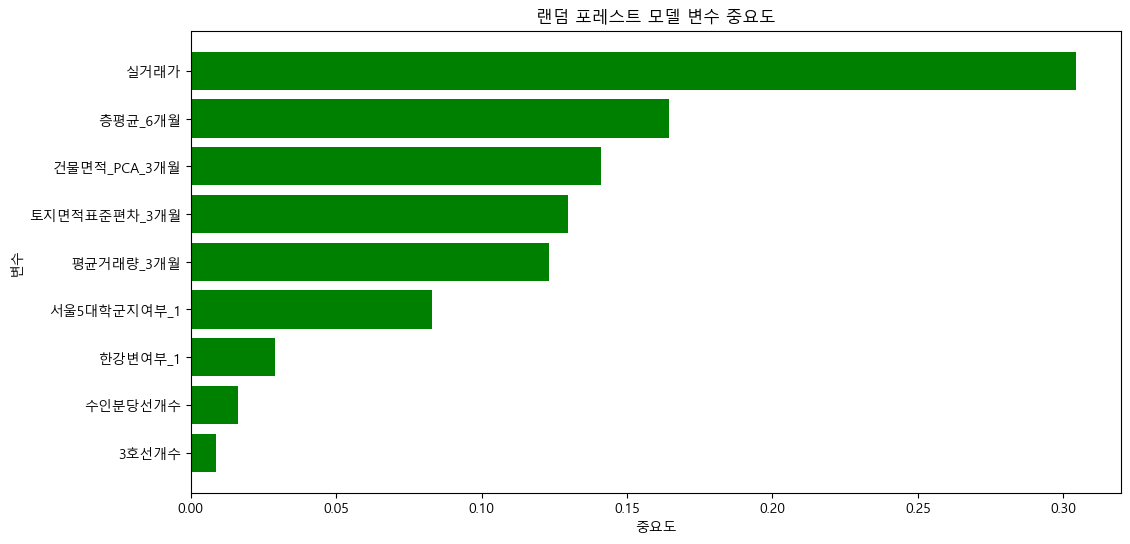

In [81]:
# 변수 중요도 추출
feature_importances = pd.DataFrame({
    'Feature': selected_features,
    'Importance': rf_model_hp.feature_importances_
}).sort_values(by='Importance', ascending=False)

# 변수 중요도 시각화
plt.figure(figsize=(12, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='green')
plt.xlabel('중요도')
plt.ylabel('변수')
plt.title('랜덤 포레스트 모델 변수 중요도')
plt.gca().invert_yaxis()  # 중요도가 높은 순으로 정렬
plt.show()


In [80]:
# 모델 저장
# joblib.dump(rf_model_hp, "C:/ZIPcoding/model/rf_model_after_hpt.joblib")

['C:/ZIPcoding/model/rf_model_after_hpt.joblib']

## 변수 추가

랜덤 포레스트 모델의 성능을 비교하기 위해, selected_features에 기본적으로 포함된 변수들을 유지하면서 추가 변수('9호선개수', '기준금리', '건축년도표준편차', '신분당선개수', '고정형주택담보대출', '연립다세대', '1호선개수')를 하나씩 추가하거나 조합하여 성능을 평가하는 실험을 진행

추가변수 선정 기준 : 상관분석 때 상관계수 절댓값 0.1 이상

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 기본 변수
selected_features = [
    '토지면적표준편차_3개월', '실거래가', '평균거래량_3개월', '건물면적_PCA_3개월',
    '서울5대학군지여부_1', '한강변여부_1', '수인분당선개수', '3호선개수', '층평균_6개월'
]

# 추가할 후보 변수
extra_features = ['9호선개수', '기준금리', '건축년도표준편차', '신분당선개수', '고정형주택담보대출', '연립다세대', '1호선개수']

# 실험할 변수 조합 생성 (기본 변수 포함)
from itertools import combinations

feature_combinations = []
for i in range(1, len(extra_features) + 1):
    for combo in combinations(extra_features, i):
        feature_combinations.append(selected_features + list(combo))

# 성능 비교 결과 저장
results = []

for features in feature_combinations:
    print(f"현재 변수 조합: {features}")

    # 결측치 및 이상치 처리
    df_for_modeling_clean = df_for_modeling.replace([np.inf, -np.inf], np.nan).dropna(subset=features + ['평당가격_6개월후'])

    # 독립변수(X)와 종속변수(y) 설정
    X = df_for_modeling_clean[features]
    y = df_for_modeling_clean['평당가격_6개월후']

    # 학습 데이터와 테스트 데이터 분리
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 랜덤 포레스트 모델 생성 및 학습
    rf_model_hp_add = RandomForestRegressor(max_depth=None,
                                    min_samples_leaf=1,
                                    min_samples_split=2,
                                    n_estimators=200,
                                    random_state=42,
                                    n_jobs=-1)
    
    rf_model_hp_add.fit(X_train, y_train)

    # 예측 수행
    y_pred = rf_model_hp_add.predict(X_test)

    # 성능 평가
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # 결과 저장
    results.append({
        '변수 조합': features,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R² Score': r2
    })

# 결과 정렬 (R² Score 기준 내림차순)
results_df = pd.DataFrame(results).sort_values(by='R² Score', ascending=False)

# 가장 성능이 높은 조합 출력
best_features = results_df.iloc[0]['변수 조합']
print(f"가장 성능이 좋은 변수 조합: {best_features}")


현재 변수 조합: ['토지면적표준편차_3개월', '실거래가', '평균거래량_3개월', '건물면적_PCA_3개월', '서울5대학군지여부_1', '한강변여부_1', '수인분당선개수', '3호선개수', '층평균_6개월', '9호선개수']
현재 변수 조합: ['토지면적표준편차_3개월', '실거래가', '평균거래량_3개월', '건물면적_PCA_3개월', '서울5대학군지여부_1', '한강변여부_1', '수인분당선개수', '3호선개수', '층평균_6개월', '기준금리']
현재 변수 조합: ['토지면적표준편차_3개월', '실거래가', '평균거래량_3개월', '건물면적_PCA_3개월', '서울5대학군지여부_1', '한강변여부_1', '수인분당선개수', '3호선개수', '층평균_6개월', '건축년도표준편차']
현재 변수 조합: ['토지면적표준편차_3개월', '실거래가', '평균거래량_3개월', '건물면적_PCA_3개월', '서울5대학군지여부_1', '한강변여부_1', '수인분당선개수', '3호선개수', '층평균_6개월', '신분당선개수']
현재 변수 조합: ['토지면적표준편차_3개월', '실거래가', '평균거래량_3개월', '건물면적_PCA_3개월', '서울5대학군지여부_1', '한강변여부_1', '수인분당선개수', '3호선개수', '층평균_6개월', '고정형주택담보대출']
현재 변수 조합: ['토지면적표준편차_3개월', '실거래가', '평균거래량_3개월', '건물면적_PCA_3개월', '서울5대학군지여부_1', '한강변여부_1', '수인분당선개수', '3호선개수', '층평균_6개월', '연립다세대']
현재 변수 조합: ['토지면적표준편차_3개월', '실거래가', '평균거래량_3개월', '건물면적_PCA_3개월', '서울5대학군지여부_1', '한강변여부_1', '수인분당선개수', '3호선개수', '층평균_6개월', '1호선개수']
현재 변수 조합: ['토지면적표준편차_3개월', '실거래가', '평균거래량_3개월', '건물면적_PCA_3개월', '서울5대학군지여부_1', '한강변

In [91]:
results_df

,변수 조합,MAE,MSE,RMSE,R² Score
111,"[토지면적표준편차_3개월, 실거래가, 평균거래량_3개월, 건물면적_PCA_3개월, ...",317.304907,539331.628418,734.392013,0.832855
124,"[토지면적표준편차_3개월, 실거래가, 평균거래량_3개월, 건물면적_PCA_3개월, ...",317.487539,540169.417366,734.962188,0.832595
96,"[토지면적표준편차_3개월, 실거래가, 평균거래량_3개월, 건물면적_PCA_3개월, ...",317.444483,540337.598667,735.076594,0.832543
88,"[토지면적표준편차_3개월, 실거래가, 평균거래량_3개월, 건물면적_PCA_3개월, ...",317.132220,540469.164479,735.166080,0.832503
76,"[토지면적표준편차_3개월, 실거래가, 평균거래량_3개월, 건물면적_PCA_3개월, ...",317.402775,540523.491704,735.203028,0.832486
...,...,...,...,...,...
6,"[토지면적표준편차_3개월, 실거래가, 평균거래량_3개월, 건물면적_PCA_3개월, ...",329.581865,573740.781310,757.456785,0.822191
24,"[토지면적표준편차_3개월, 실거래가, 평균거래량_3개월, 건물면적_PCA_3개월, ...",329.562173,574292.102096,757.820627,0.822020
0,"[토지면적표준편차_3개월, 실거래가, 평균거래량_3개월, 건물면적_PCA_3개월, ...",329.832747,575019.435684,758.300360,0.821795
9,"[토지면적표준편차_3개월, 실거래가, 평균거래량_3개월, 건물면적_PCA_3개월, ...",329.911633,575898.234091,758.879591,0.821523


In [89]:
# results_df.to_pickle("C:/ZIPcoding/model/features_result_df.pkl")

가장 성능이 좋은 변수 조합: ['토지면적표준편차_3개월', '실거래가', '평균거래량_3개월', '건물면적_PCA_3개월', '서울5대학군지여부_1', '한강변여부_1', '수인분당선개수', '3호선개수', '층평균_6개월', '9호선개수', '건축년도표준편차', '고정형주택담보대출', '연립다세대', '1호선개수']

In [87]:
# 컬럼명 변경
df_for_modeling = df_for_modeling.rename(columns={'연립다세대': '당일거래된연립다세대건물수'})

## 최종 모델 학습

In [89]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

selected_features =  ['토지면적표준편차_3개월', '실거래가', '평균거래량_3개월', '건물면적_PCA_3개월', '서울5대학군지여부_1',
                      '한강변여부_1', '수인분당선개수', '3호선개수', '층평균_6개월', '9호선개수', '건축년도표준편차', '고정형주택담보대출',
                      '당일거래된연립다세대건물수', '1호선개수']

# 결측치 및 이상치 처리
df_for_modeling = df_for_modeling.replace([np.inf, -np.inf], np.nan).dropna(subset=selected_features + ['평당가격_6개월후'])

# 독립변수(X)와 종속변수(y) 설정
X = df_for_modeling[selected_features]
y = df_for_modeling['평당가격_6개월후']

# 학습 데이터와 테스트 데이터 분리 (80% 학습, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 최적의 하이퍼파라미터 전달 방식
rf_model_final = RandomForestRegressor(max_depth=None,
                                        min_samples_leaf=1,
                                        min_samples_split=2,
                                        n_estimators=200,
                                        random_state=42,
                                        n_jobs=-1)

# 모델 학습
rf_model_final.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

In [90]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 예측 수행
y_pred = rf_model_final.predict(X_test)

# 성능 평가
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"📌 모델 성능 평가")
print(f"MAE (평균 절대 오차): {mae:.4f}")
print(f"MSE (평균 제곱 오차): {mse:.4f}")
print(f"RMSE (평균 제곱근 오차): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


📌 모델 성능 평가
MAE (평균 절대 오차): 317.3049
MSE (평균 제곱 오차): 539331.6284
RMSE (평균 제곱근 오차): 734.3920
R² Score: 0.8329


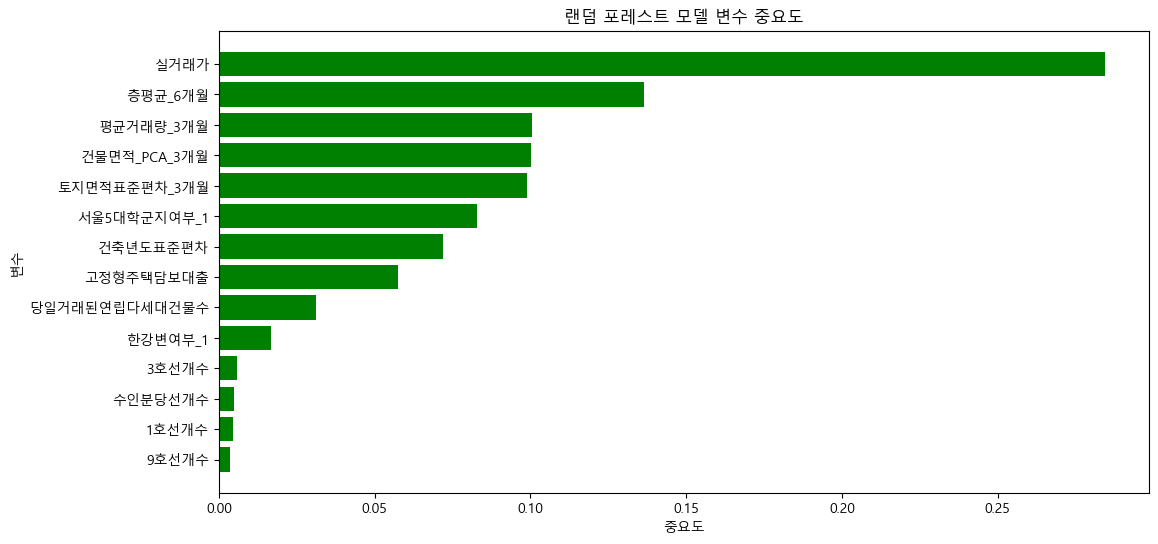

In [95]:
# 변수 중요도 추출
feature_importances = pd.DataFrame({
    'Feature': selected_features,
    'Importance': rf_model_final.feature_importances_
}).sort_values(by='Importance', ascending=False)

# 변수 중요도 시각화
plt.figure(figsize=(12, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='green')
plt.xlabel('중요도')
plt.ylabel('변수')
plt.title('랜덤 포레스트 모델 변수 중요도')
plt.gca().invert_yaxis()  # 중요도가 높은 순으로 정렬
plt.savefig("C:/ZIPcoding/model/최종모델변수중요도.png", bbox_inches='tight')
plt.show()


In [222]:
# 모델 저장
# joblib.dump(rf_model_final, "C:/ZIPcoding/model/rf_model_final.joblib")

['C:/ZIPcoding/model/rf_model_final.joblib']

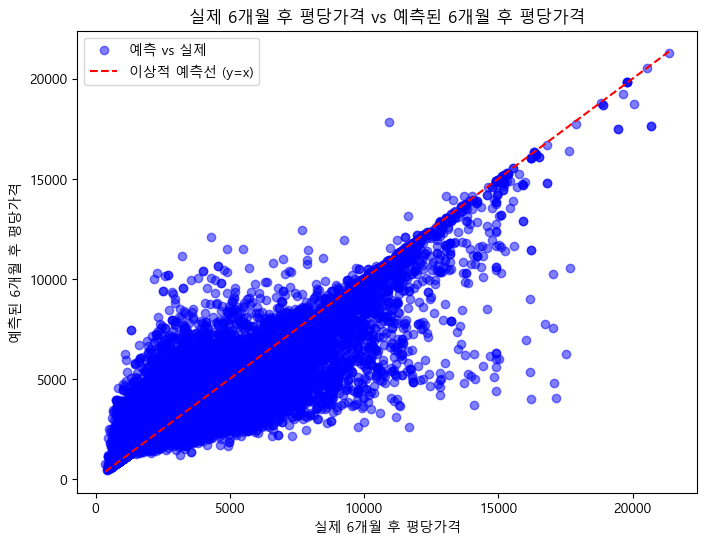

In [240]:
import matplotlib.pyplot as plt
import numpy as np

# 그래프 크기 설정 (가로 8, 세로 6)
plt.figure(figsize=(8, 6))

# 실제 평당가격(y_test_final)과 예측된 평당가격(y_pred_final) 산점도
plt.scatter(y_test, y_pred, alpha=0.5, color="blue", label="예측 vs 실제")

# 이상적인 예측선을 추가 (y=x, 즉 실제값과 예측값이 같을 경우의 기준선)
plt.plot([min(y_test), max(y_test)], 
         [min(y_test), max(y_test)], 
         linestyle="--", color="red", label="이상적 예측선 (y=x)")

# 축 및 제목 설정
plt.xlabel("실제 6개월 후 평당가격")  # X축: 실제 평당가격
plt.ylabel("예측된 6개월 후 평당가격")  # Y축: 예측된 평당가격
plt.title("실제 6개월 후 평당가격 vs 예측된 6개월 후 평당가격")  # 그래프 제목

# 범례 추가
plt.legend()

plt.savefig("C:/ZIPcoding/model/모델예측결과시각화.png")

# 그래프 출력
plt.show()


##### 이 그래프에서 확인할 수 있는 점
- 전반적으로 y=x(빨간 점선)를 따라가는 경향

- 모델이 대체적으로 실제값과 비슷한 예측을 하고 있음.
즉, 전반적으로 예측 성능이 나쁘지 않음.
일부 데이터에서 과소예측(Underprediction) 발생

- 위쪽에 있는 점들: 실제값보다 예측값이 낮음 → 고가 지역에서 예측이 낮게 나올 가능성
모델이 높은 가격대에서는 실제값보다 낮게 예측하는 경향이 있을 수 있음.
저가 구간에서는 예측이 다소 분산됨

- 그래프 왼쪽 아래 부분을 보면 데이터가 다소 퍼져 있음.
즉, 낮은 가격대에서는 예측값의 변동이 크고, 정확도가 낮을 가능성이 있음.
원인은 데이터가 부족하거나, 특정 변수의 영향을 과소평가했을 수도 있음.

#### 모델 개선 방향
##### 고가 구간에서 과소예측 문제 해결
- 비선형 특성 추가 → 로그 변환, 다항 특징 추가
- 트리 모델의 깊이 증가 → max_depth 조정

##### 저가 구간에서 변동성 줄이기
- 이상치 처리 → 극단적으로 낮은 가격을 제거 또는 조정
- 추가적인 변수 고려 → 주변 인프라, 학군, 입지 등의 변수를 추가

##### 전체적인 성능 향상
- GridSearchCV나 RandomizedSearchCV로 하이퍼파라미터 튜닝
- 다른 회귀 모델(LightGBM, XGBoost)과 비교

In [9]:
import joblib

# 모델 불러오기
rf_model_final = joblib.load("C:/ZIPcoding/model/rf_model_final.joblib")

## 예측 수행

In [11]:
import pandas as pd

df = pd.read_pickle("C:/ZIPcoding/final_encoded_df.pkl")

In [12]:
final_features =  ['토지면적표준편차_3개월', '실거래가', '평균거래량_3개월', '건물면적_PCA_3개월', '서울5대학군지여부_1',
                    '한강변여부_1', '수인분당선개수', '3호선개수', '층평균_6개월', '9호선개수', '건축년도표준편차', '고정형주택담보대출',
                    '당일거래된연립다세대건물수', '1호선개수']

In [15]:
# 컬럼명 변경
df = df.rename(columns={'연립다세대': '당일거래된연립다세대건물수'})

In [17]:
x = df[final_features]

In [19]:
pred = rf_model_final.predict(x)

In [20]:
len(pred)

515083

In [23]:
df['6개월후_예측평당가격'] = pred

In [25]:
df = df.sort_values(by = '계약일', ascending = False)

In [27]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 515083 entries, 0 to 515082
Data columns (total 63 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   자치구코드          515083 non-null  int32         
 1   법정동코드          515083 non-null  int32         
 2   전체코드           515083 non-null  object        
 3   자치구명           515083 non-null  object        
 4   법정동명           515083 non-null  object        
 5   자치구법정동         515083 non-null  object        
 6   계약일            515083 non-null  datetime64[ns]
 7   평당가격           515083 non-null  float64       
 8   실거래가           515083 non-null  int32         
 9   geometry       515083 non-null  geometry      
 10  포함지하철역         515083 non-null  object        
 11  환승역개수          515083 non-null  int64         
 12  일반역개수          515083 non-null  int64         
 13  1호선개수          515083 non-null  int64         
 14  2호선개수          515083 non-null  int64         
 1

In [29]:

# 최신 계약일 기준 정렬 (최신 데이터가 위로 오도록 정렬)
df_sorted = df.sort_values(by=['자치구코드', '법정동코드', '계약일'], ascending=[True, True, False])

# '평당가격평균_3개월'이 NaN이 아닌 가장 최신 행 찾기
df_filtered = df_sorted.groupby(['자치구코드', '법정동코드'], as_index=False).apply(
    lambda group: group.dropna(subset=['평당가격평균_3개월']).head(1)  # NaN이 아닌 최신 데이터 1개 선택
).reset_index(drop=True)

# 같은 자치구의 평균값으로 NaN 대체
gu_avg_price = df.groupby('자치구코드')['평당가격평균_3개월'].transform('mean')
df_filtered['평당가격평균_3개월'] = df_filtered['평당가격평균_3개월'].fillna(gu_avg_price)

# 그래도 NaN이면 최신 계약일 이전 데이터에서 가장 최근의 값을 찾아 대체
for index, row in df_filtered[df_filtered['평당가격평균_3개월'].isna()].iterrows():
    gu_code, dong_code = row['자치구코드'], row['법정동코드']
    
    # 최신 계약일을 제외한 과거 데이터 중 가장 최근 값 찾기
    past_data = df_sorted[(df_sorted['자치구코드'] == gu_code) & 
                          (df_sorted['법정동코드'] == dong_code) & 
                          (df_sorted['계약일'] < row['계약일'])]  # 최신 계약일 제외
    
    # 과거 데이터에서 '평당가격평균_3개월'이 NaN이 아닌 가장 최근 값 찾기
    if not past_data.empty:
        past_price = past_data.dropna(subset=['평당가격평균_3개월'])['평당가격평균_3개월'].iloc[0] if not past_data.dropna(subset=['평당가격평균_3개월']).empty else None
        if past_price is not None:
            df_filtered.at[index, '평당가격평균_3개월'] = past_price

C:\Users\user\AppData\Local\Temp\ipykernel_2748\2949888445.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_sorted.groupby(['자치구코드', '법정동코드'], as_index=False).apply(


In [31]:
df_filtered.shape

(381, 63)

In [33]:
import pandas as pd

# 원본 데이터에서 모든 자치구+법정동 조합 찾기
original_combinations = df[['자치구코드', '법정동코드']].drop_duplicates()

# `df_filtered`에서 남아 있는 조합 찾기
filtered_combinations = df_filtered[['자치구코드', '법정동코드']].drop_duplicates()

# 원본에는 있지만 필터링 후 없는 법정동 찾기
missing_combinations = original_combinations.merge(filtered_combinations, on=['자치구코드', '법정동코드'], how='left', indicator=True)
missing_combinations = missing_combinations[missing_combinations['_merge'] == 'left_only'].drop(columns=['_merge'])


In [35]:
missing_combinations

,자치구코드,법정동코드
183,11410,11500
358,11110,11000
368,11500,11000
372,11110,14800
374,11140,15000
386,11110,10600
387,11110,10500
388,11110,14300
389,11110,13600


In [37]:
import pandas as pd

# 누락된 법정동 조합을 포함한 데이터 가져오기
missing_combinations_list = [
    (11410, 11500), (11110, 11000), (11500, 11000), (11110, 14800),
    (11140, 15000), (11110, 10600), (11110, 10500), (11110, 14300), (11110, 13600)
]
missing_combinations_df = pd.DataFrame(missing_combinations_list, columns=['자치구코드', '법정동코드'])

# 해당 법정동 중에서 가장 최신 계약일을 가진 행 찾기
latest_missing_data = df[df[['자치구코드', '법정동코드']].apply(tuple, axis=1).isin(missing_combinations_list)]
latest_missing_data = latest_missing_data.sort_values(by=['자치구코드', '법정동코드', '계약일'], ascending=[True, True, False])
latest_missing_data = latest_missing_data.groupby(['자치구코드', '법정동코드']).head(1)

# 해당 자치구의 '평당가격평균_3개월' 평균값 계산 후 NaN 채우기
gu_avg_price = df.groupby('자치구코드')['평당가격평균_3개월'].transform('mean')
latest_missing_data['평당가격평균_3개월'] = latest_missing_data['평당가격평균_3개월'].fillna(latest_missing_data['자치구코드'].map(gu_avg_price))

# 기존 df_filtered와 합치기
df_filled = pd.concat([df_filtered, latest_missing_data], ignore_index=True)

In [39]:
# '평당가격평균_3개월'이 NaN인 행들을 대상으로 같은 자치구 & 계약일의 평균값으로 대체
for index, row in df_filtered[df_filtered['평당가격평균_3개월'].isna()].iterrows():
    gu_code, contract_date = row['자치구코드'], row['계약일']
    
    # 같은 자치구 & 같은 계약일의 '평당가격평균_3개월' 평균값 계산 (NaN 제외)
    avg_price = df_filtered[(df_filtered['자치구코드'] == gu_code) & 
                            (df_filtered['계약일'] == contract_date)]['평당가격평균_3개월'].mean()
    
    # NaN이 아닐 경우 해당 평균값으로 채우기
    if not pd.isna(avg_price):
        df_filtered.at[index, '평당가격평균_3개월'] = avg_price

In [41]:
df_filled

,자치구코드,법정동코드,전체코드,자치구명,법정동명,자치구법정동,계약일,평당가격,실거래가,geometry,...,아파트,당일거래된연립다세대건물수,오피스텔,건축년도평균,건축년도중앙값,건축년도표준편차,건물면적_PCA_3개월,서울5대학군지여부_1,한강변여부_1,6개월후_예측평당가격
0,11110,10100,1111010100,종로구,청운동,종로구 청운동,2025-01-30,3507.5797,61000,"POLYGON ((196524.183 453809.266, 196541.751 45...",...,0,1,0,2002.684932,2001.0,11.874198,8.347818e+00,0,0,3562.342679
1,11110,10200,1111010200,종로구,신교동,종로구 신교동,2025-01-06,3237.4831,58000,"POLYGON ((196842.923 453698.495, 196851.398 45...",...,0,1,0,2000.909091,1999.0,6.590402,3.392979e-01,0,0,3475.749539
2,11110,10400,1111010400,종로구,효자동,종로구 효자동,2022-06-10,1700.4997,33000,"POLYGON ((197595.39 453437.201, 197594.236 453...",...,0,1,0,2000.928571,2002.5,3.099982,1.081036e+01,0,0,3101.452048
3,11110,10700,1111010700,종로구,적선동,종로구 적선동,2024-08-19,2473.5450,34000,"POLYGON ((197648.783 452685.06, 197649.804 452...",...,0,0,3,2003.000000,2003.0,0.000000,-3.901810e-01,0,0,2983.664411
4,11110,10800,1111010800,종로구,통인동,종로구 통인동,2024-12-23,1180.6798,22000,"POLYGON ((197175.327 453140.953, 197173.195 45...",...,1,0,0,1999.375000,1999.0,4.068608,2.599431e-01,0,0,3439.385006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,11110,14300,1111014300,종로구,화동,종로구 화동,2020-12-03,1437.2996,72000,"POLYGON ((198428.88 453306.251, 198440.754 453...",...,0,1,0,1996.000000,1996.0,NaN,-6.137252e-16,0,0,3771.489436
386,11110,14800,1111014800,종로구,계동,종로구 계동,2024-07-30,3073.2052,79000,"POLYGON ((198728.626 454061.645, 198731.379 45...",...,0,1,0,1998.600000,1997.0,2.190890,-6.137252e-16,0,0,4069.806544
387,11140,15000,1114015000,중구,을지로4가,중구 을지로4가,2024-06-24,3054.1263,27700,"POLYGON ((199516.009 451517.607, 199500.003 45...",...,0,0,1,2019.000000,2019.0,0.000000,-6.137252e-16,0,0,3019.028484
388,11410,11500,1141011500,서대문구,봉원동,서대문구 봉원동,2025-02-03,1844.1249,75000,"POLYGON ((194929.569 452076.127, 194934.454 45...",...,0,1,0,2022.000000,2022.0,NaN,-6.137252e-16,0,0,4233.343140


In [43]:
# 상승률 또는 하락률(%) 계산하여 새 컬럼 생성
df_filled['평당가격_6개월후_변동률_퍼센트'] = ((df_filled['6개월후_예측평당가격'] - df_filled['평당가격평균_3개월']) / df_filled['평당가격평균_3개월']) * 100

In [45]:
# 변동률(%) 기준으로 정렬하여 순위 컬럼 추가 (내림차순: 높은 변동률이 1위)
df_filled['변동률_순위'] = df_filled['평당가격_6개월후_변동률_퍼센트'].rank(method='dense', ascending=False).astype(int)

In [47]:
predict_result = df_filled.sort_values(by = '변동률_순위')

In [49]:
predict_result['예상시세차익'] = predict_result['6개월후_예측평당가격'] - predict_result['평당가격평균_3개월']

In [ ]:
predict_result.to_pickle("C:/ZIPcoding/predict_result.pkl")

In [51]:
predict_result.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 390 entries, 176 to 43
Data columns (total 66 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   자치구코드              390 non-null    int32         
 1   법정동코드              390 non-null    int32         
 2   전체코드               390 non-null    object        
 3   자치구명               390 non-null    object        
 4   법정동명               390 non-null    object        
 5   자치구법정동             390 non-null    object        
 6   계약일                390 non-null    datetime64[ns]
 7   평당가격               390 non-null    float64       
 8   실거래가               390 non-null    int32         
 9   geometry           390 non-null    geometry      
 10  포함지하철역             390 non-null    object        
 11  환승역개수              390 non-null    int64         
 12  일반역개수              390 non-null    int64         
 13  1호선개수              390 non-null    int64         
 14  2호선개수 

In [57]:
predict_result

,자치구코드,법정동코드,전체코드,자치구명,법정동명,자치구법정동,계약일,평당가격,실거래가,geometry,...,건축년도평균,건축년도중앙값,건축년도표준편차,건물면적_PCA_3개월,서울5대학군지여부_1,한강변여부_1,6개월후_예측평당가격,평당가격_6개월후_변동률_퍼센트,변동률_순위,예상시세차익
176,11290,11700,1129011700,성북구,동선동2가,성북구 동선동2가,2021-05-28,734.73280,10500,"POLYGON ((201589.931 454043.828, 201584.175 45...",...,1995.428571,1996.0,1.511858,-1.472579,0,0,4794.309847,644.231892,1,4150.114147
22,11110,14000,1111014000,종로구,삼청동,종로구 삼청동,2024-01-10,658.68260,12000,"POLYGON ((197597.738 454551.228, 197599.086 45...",...,2001.833333,2003.0,3.188521,0.359561,0,0,4281.063407,549.943297,2,3622.380807
65,11140,13800,1114013800,중구,필동2가,중구 필동2가,2021-03-26,1681.76670,22500,"POLYGON ((199508.836 451005.115, 199511.376 45...",...,2017.108108,2022.0,11.517580,-1.131480,0,0,5348.096441,304.777503,3,4026.852941
276,11500,10700,1150010700,강서구,외발산동,강서구 외발산동,2024-12-06,948.71210,12500,"MULTIPOLYGON (((184364.361 450401.729, 184374....",...,2002.741573,2002.0,7.449112,-0.842541,0,0,3053.316085,285.470859,4,2261.215718
37,11110,17000,1111017000,종로구,명륜1가,종로구 명륜1가,2024-09-27,2450.08290,51500,"POLYGON ((199957.776 453792.318, 199954.714 45...",...,2005.955357,2003.0,9.379284,0.735884,0,0,4383.587949,220.088157,5,3014.093999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,11440,10900,1144010900,마포구,염리동,마포구 염리동,2025-02-08,5114.97190,91000,"POLYGON ((195559.45 449959.051, 195558.536 449...",...,1836.373099,2003.0,565.692510,0.976119,0,0,3632.704615,-54.194465,386,-4298.006406
113,11170,12700,1117012700,용산구,용산동5가,용산구 용산동5가,2024-09-30,8507.16235,335000,"POLYGON ((197085.807 447242.32, 197097.263 447...",...,2009.000000,2009.0,0.000000,3.751132,0,0,4115.064340,-55.014192,387,-5032.407960
44,11110,17900,1111017900,종로구,홍파동,종로구 홍파동,2025-02-01,8985.67810,231000,"POLYGON ((196622.023 452140.285, 196629.798 45...",...,2016.606557,2017.0,2.641254,1.757185,0,0,3796.751666,-56.964261,388,-5025.570734
120,11170,13400,1117013400,용산구,주성동,용산구 주성동,2025-01-10,7867.13290,150000,"POLYGON ((199700.336 446952.738, 199717.024 44...",...,1982.884615,1976.0,9.770678,3.059646,0,0,5562.652852,-61.187854,389,-8769.594748


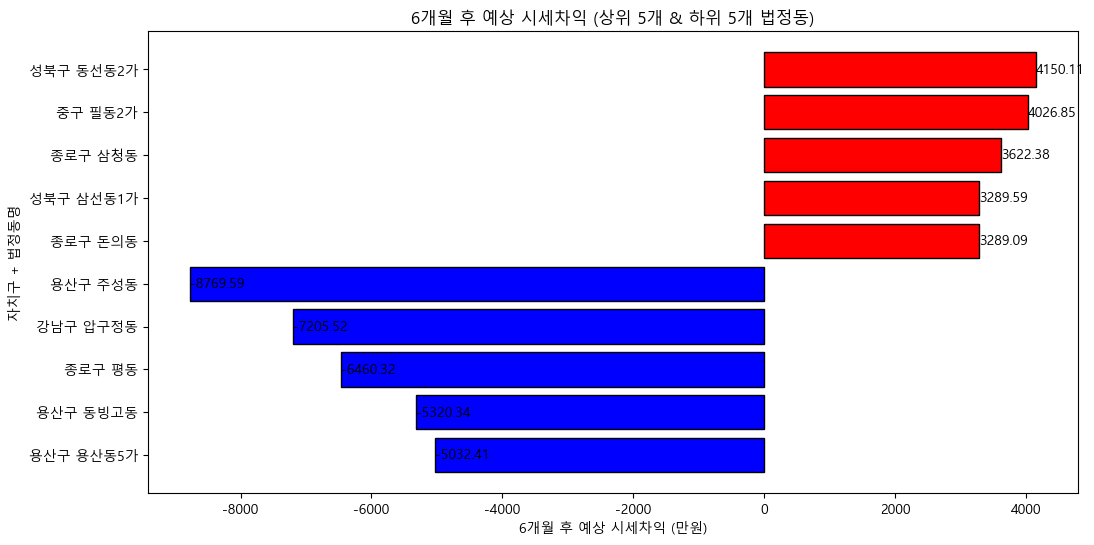

In [55]:
import matplotlib.pyplot as plt
import pandas as pd

# 자치구법정동 기준으로 그룹화하여 평균 예상 시세차익 계산
grouped_result = predict_result.groupby(["자치구법정동"])["예상시세차익"].mean().reset_index()

# 상위 5개 & 하위 5개 선택
top_5 = grouped_result.sort_values(by="예상시세차익", ascending=False).head(5)
bottom_5 = grouped_result.sort_values(by="예상시세차익", ascending=True).head(5)

# 상위 5개 + 하위 5개 결합
top_bottom_5 = pd.concat([top_5, bottom_5])

# 그래프 크기 설정
plt.figure(figsize=(12, 6))

# 색상 지정 (상위 5개: 파란색, 하위 5개: 빨간색)
colors = ["red"] * 5 + ["blue"] * 5
plt.barh(top_bottom_5["자치구법정동"], top_bottom_5["예상시세차익"], color=colors, edgecolor="black")

# 그래프 스타일 설정
plt.xlabel("6개월 후 예상 시세차익 (만원)")
plt.ylabel("자치구 + 법정동명")
plt.title("6개월 후 예상 시세차익 (상위 5개 & 하위 5개 법정동)")
plt.gca().invert_yaxis()  # 순위를 위에서 아래로 표시

# 값 표시 (각 바의 끝에 값 출력)
for index, value in enumerate(top_bottom_5["예상시세차익"]):
    plt.text(value, index, f"{value:.2f}", va="center", fontsize=10)

# 그래프 저장
plt.savefig("C:/ZIPcoding/model/top_bottom_5_expected_profit.png", dpi=300, bbox_inches="tight")

# 그래프 출력
plt.show()


In [59]:
predict_result.to_pickle("C:/ZIPcoding/model/predict_result.pkl")

In [61]:
# df_filled['평당가격평균_3개월']

x = df_filled[final_features]
pred = rf_model_final.predict(x)

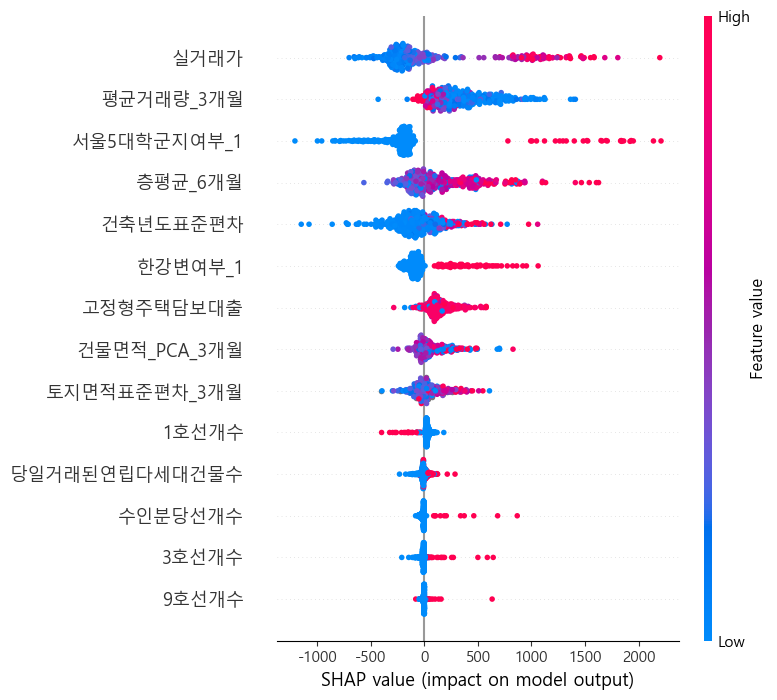

In [63]:
import shap

# TreeExplainer 사용
explainer = shap.TreeExplainer(rf_model_final)
shap_values = explainer.shap_values(x)

# SHAP summary plot
shap.summary_plot(shap_values, x)


In [64]:
pd.DataFrame(shap_values)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,16.447586,39.437737,117.381560,281.551346,-212.170236,-85.739234,-5.983778,-3.992688,-12.876457,-3.214982,-143.375631,181.472916,17.199758,26.419772
1,-31.596365,-95.848406,183.022423,-17.297406,-179.648797,-115.940492,-5.203042,-4.279752,337.678760,-0.714974,-301.224561,169.061565,29.960595,26.487155
2,64.966514,-317.304067,414.111125,400.701318,-229.872311,-213.318781,-5.831714,-0.619973,-109.411354,-3.933168,-186.640999,155.871954,28.278170,21.651026
3,57.041791,-290.620275,565.689275,-30.209144,-200.692827,-218.561794,-5.800825,22.158756,-22.491044,-2.846889,-208.237262,44.363660,-2.777608,20.025521
4,17.955009,-408.628048,690.109319,-34.216188,-141.642205,-193.628290,-6.085721,-8.034563,54.379261,-4.196109,-118.371041,170.709583,51.276553,19.972436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,13.293566,-155.508124,506.048236,-31.505720,-150.529831,-141.305192,-6.196838,-5.314389,463.147321,-2.287629,-102.508103,-70.271558,47.878767,18.745404
386,-32.548927,-56.209615,428.534983,-15.891432,-127.025092,-158.777581,-5.701790,-3.985273,368.542415,-3.845111,-288.408083,195.041686,76.987971,19.584000
387,122.139877,-263.587056,933.436516,-45.247535,-130.799532,-163.160724,-5.401472,-3.167075,807.555142,0.236574,-242.943243,161.634410,91.345834,22.683297
388,-25.132667,-58.400315,447.769500,-26.412005,-155.684784,-169.454018,-5.428133,-3.338697,284.395691,-4.104844,-319.783179,95.196019,50.061718,20.266969


In [ ]:
pd.DataFrame(shap_values).to_pickle("C:/ZIPcoding/model/shap_values.pkl")